In [1]:
#libraries for plotting
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

#libraries for data cleaning and tidying
import pandas as pd
import numpy as np

#Libraries for model
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, roc_auc_score, roc_curve, accuracy_score

#Plot style
plt.style.use('fivethirtyeight')
#Plot sizing
plt.rcParams["figure.figsize"] = [15, 7.5]

# TO DO:

### - Better model validation using more metrics
### - Add predictions to all three seasons of data
### - Add better commentary explaining what I am doing and the results of doing such

In [2]:
#read in data
pbp18 = pd.read_csv('pbp18.csv')
drives18 = pd.read_csv('drives18.csv')

In [3]:
#get rid of Unnamed column
pbp18.drop('Unnamed: 0', axis = 1, inplace = True)
drives18.drop('Unnamed: 0', axis = 1, inplace = True)

#view first five rows
pbp18.head(5)

,game_id,drive_id,play_id,home,away,offense_team,defense_team,down,distance,yard_line,...,ytg,play_text,play_type,ppa,scoring,qtr,offense_score,defense_score,offense_conf,defense_conf
0,401012246,4010122461,401012246101849902,Alabama,Louisville,Louisville,Alabama,1,10,65,...,65,Evan O'Hara kickoff for 58 yds,Kickoff,NaN,False,1,0,0,ACC,SEC
1,401012246,4010122461,401012246101857401,Alabama,Louisville,Alabama,Louisville,1,10,35,...,65,Damien Harris run for 3 yds to the Alab 38,Rush,-0.406231,False,1,0,0,SEC,ACC
2,401012246,4010122461,401012246101858901,Alabama,Louisville,Alabama,Louisville,2,7,38,...,62,Tua Tagovailoa sacked by G.G. Robinson for a l...,Sack,-1.426442,False,1,0,0,SEC,ACC
3,401012246,4010122461,401012246101864901,Alabama,Louisville,Alabama,Louisville,3,13,32,...,68,Tua Tagovailoa pass complete to Damien Harris ...,Pass Reception,2.890492,False,1,0,0,SEC,ACC
4,401012246,4010122461,401012246101867401,Alabama,Louisville,Alabama,Louisville,1,10,46,...,54,Tua Tagovailoa pass complete to Irv Smith Jr. ...,Pass Reception,0.646573,False,1,0,0,SEC,ACC


### Add a few features to our data set

In [4]:
#add success column -- these cutoffs are used by Football Outsiders
#(SportsSource Analytics uses .4, .5, conversion, conversion splits)
pbp18['success'] = np.where((pbp18['yards_gained'] >= .5 * pbp18['distance']) & (pbp18['down'] == 1), 1, 
                           np.where((pbp18['yards_gained'] >= .7 * pbp18['distance']) & (pbp18['down'] == 2), 1, 
                                   np.where((pbp18['yards_gained'] >= pbp18['distance']) & ((pbp18['down'] == 3) | (pbp18['down'] == 4)), 1, 0)))

#add ppa success column -- sucess if ppa > 0
pbp18['ppa_success'] = np.where(pbp18['ppa'] > 0, 1, 0)

#add score differential column
pbp18['score_diff'] = pbp18['offense_score'] - pbp18['defense_score']

#add absolute value score differential column
pbp18['abs_diff'] = abs(pbp18['score_diff'])

#view some of the added features and see if they worked properly
pbp18[['down', 'distance', 'yards_gained', 'ytg', 'success', 'play_text', 'ppa', 'ppa_success', 'abs_diff', 'drive_id']].head(5)

,down,distance,yards_gained,ytg,success,play_text,ppa,ppa_success,abs_diff,drive_id
0,1,10,0,65,0,Evan O'Hara kickoff for 58 yds,NaN,0,0,4010122461
1,1,10,3,65,0,Damien Harris run for 3 yds to the Alab 38,-0.406231,0,0,4010122461
2,2,7,-6,62,0,Tua Tagovailoa sacked by G.G. Robinson for a l...,-1.426442,0,0,4010122461
3,3,13,14,68,1,Tua Tagovailoa pass complete to Damien Harris ...,2.890492,1,0,4010122461
4,1,10,7,54,1,Tua Tagovailoa pass complete to Irv Smith Jr. ...,0.646573,1,0,4010122461


In [5]:
#get drives data from pbp data -- filter out certain plays (Kickoffs, Punts)
drive_advanced_stats = pbp18.query('(play_type != "Kickoff") & (play_type ! = "Punt") & (play_type != "Timeout") & (play_type != "Uncategorized")').groupby('drive_id').agg(ppa_per_play = ('ppa', 'mean'), sr = ('success', 'mean'), ppa_sr = ('ppa_success', 'mean')).reset_index()

In [6]:
#join drives18 with drives advanced stats
drives18 = drives18.merge(drive_advanced_stats, how = 'inner', on = 'drive_id')

#add reduced_result variable to make limited result classifications
drives18['reduced_result'] = np.where(drives18['drive_result'] == 'TD', 'TD', 
        np.where(drives18['drive_result'] == 'FG', 'FG', 
                 np.where(drives18['drive_result'].isin(['FUMBLE', 'INT', 'INT TD', 'FUMBLE TD', 'FUMBLE RETURN TD']), 'TO', 
                          'NON-SCORE')))

drives18.head(5)

,drive_id,offense,defense,drive_number,start_period,start_time_min,start_time_sec,start_yardline,start_ytg,drive_result,...,end_yardline,end_ytg,num_plays,score,yards_gained,game_id,ppa_per_play,sr,ppa_sr,reduced_result
0,4010122461,Alabama,Louisville,1,1,15,0,35,65,TD,...,100,0,7,True,65,401012246,0.748960,0.714286,0.714286,TD
1,4010122462,Louisville,Alabama,2,1,11,55,75,75,PUNT,...,55,55,4,False,20,401012246,-0.091160,0.500000,0.500000,NON-SCORE
2,4010122463,Alabama,Louisville,3,1,10,10,20,80,FUMBLE,...,65,35,8,False,63,401012246,0.451487,0.500000,0.375000,TO
3,4010122464,Louisville,Alabama,4,1,7,4,83,83,PUNT,...,84,84,3,False,-1,401012246,-0.200389,0.000000,0.000000,NON-SCORE
4,4010122465,Alabama,Louisville,5,1,6,4,45,55,TD,...,100,0,6,True,55,401012246,0.712769,0.833333,0.666667,TD


In [7]:
#import packages to run Naive Bayes model
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, roc_auc_score, roc_curve, accuracy_score

In [8]:
#get rid of nan values (happens on kickoff-turnovers(?))
drives18 = drives18[-drives18.isnull().any(axis = 1)]

#get model data
drives_model_data = drives18[['start_period', 'start_ytg', 'end_period', 'ppa_per_play', 'sr', 'reduced_result', 'num_plays']]

#split into test and training sets
train, test = train_test_split(drives_model_data, test_size = .25, stratify = drives_model_data.reduced_result, random_state = 801)

#split into x's and y's
x_train = train.drop('reduced_result', axis = 1)
x_test = test.drop('reduced_result', axis = 1)
y_train = train['reduced_result']
y_test = test['reduced_result']

In [9]:
##   --- C O N S I D E R   U S I N G   A   P I P E L I N E ---

#optimize model parameters (**this takes a long time to run)
parameters = {'max_depth':list(range(1, 15, 1))}
gb_par = GradientBoostingClassifier()

# *** comment out below lines so it does not need to run every time I restart the Kernel

#param_gb = GridSearchCV(gb_par, parameters)
#param_gb.fit(x_train, y_train)

#print out optimal parameter
#print(param_gb.best_params_)

#optimal max_depth is 6

In [10]:
#Gradient Boosting -- use parameter found above
gb = GradientBoostingClassifier(max_depth = 6)
gb.fit(x_train, y_train)
yhat_gb = (gb.predict(x_test))

In [11]:
## --- W H A T   O T H E R   M E T R I C S   C A N   I   U S E??? ---


print('Gradient Boosting:')
print('Accuracy:', accuracy_score(y_test, yhat_gb))

Gradient Boosting:
Accuracy: 0.8648938068891665


In [12]:
#add predictions to drives18
drives18['preds'] = pd.Series(gb.predict(drives_model_data.drop('reduced_result', axis = 1)))

drives18['actual_points'] = np.where(drives18['reduced_result'] == "TD", 7, 
                             np.where(drives18['reduced_result'] == "FG", 3, 0))
drives18['predicted_points'] = np.where(drives18['preds'] == "TD", 7, 
                             np.where(drives18['preds'] == "FG", 3, 0))

# TEST THE MODEL (with 2020 data)

In [13]:
#read in 2020 data
pbp20 = pd.read_csv('pbp20.csv')
drives20 = pd.read_csv('drives20.csv')

#### CLEAN 2020 data to use in the model

In [14]:
#get rid of Unnamed column
pbp20.drop('Unnamed: 0', axis = 1, inplace = True)
drives20.drop('Unnamed: 0', axis = 1, inplace = True)

#add success column
pbp20['success'] = np.where((pbp20['yards_gained'] >= .5 * pbp20['distance']) & (pbp20['down'] == 1), 1, 
                           np.where((pbp20['yards_gained'] >= .7 * pbp20['distance']) & (pbp20['down'] == 2), 1, 
                                   np.where((pbp20['yards_gained'] >= pbp20['distance']) & ((pbp20['down'] == 3) | (pbp20['down'] == 4)), 1, 0)))

#add ppa success column
pbp20['ppa_success'] = np.where(pbp20['ppa'] > 0, 1, 0)

#add score differential column
pbp20['score_diff'] = pbp20['offense_score'] - pbp20['defense_score']

#add absolute value score differential column
pbp20['abs_diff'] = abs(pbp20['score_diff'])

#get drives data from pbp data -- filter out certain plays (Kickoffs, Punts)
drive_advanced_stats20 = pbp20.query('(play_type != "Kickoff") & (play_type ! = "Punt") & (play_type != "Timeout") & (play_type != "Uncategorized")').groupby('drive_id').agg(ppa_per_play = ('ppa', 'mean'), sr = ('success', 'mean'), ppa_sr = ('ppa_success', 'mean')).reset_index()

#join drives20 with drives advanced stats
drives20 = drives20.merge(drive_advanced_stats20, how = 'inner', on = 'drive_id')

#add reduced_result variable to make limited result classifications
drives20['reduced_result'] = np.where(drives20['drive_result'] == 'TD', 'TD', 
        np.where(drives20['drive_result'] == 'FG', 'FG', 
                np.where(drives20['drive_result'].isin(['FUMBLE', 'INT', 'INT TD', 'FUMBLE TD', 'FUMBLE RETURN TD']), 'TO', 
                        'NON-SCORE')))

#get 2020 data in a format that can be passed into the model
drives20 = drives20[-drives20.isnull().any(axis = 1)]
drives_model_data20 = drives20[['start_period', 'start_ytg', 'end_period', 'ppa_per_play', 'sr', 'num_plays']]

#get predictions for 2020 and add predictions to dataframe
drives20['preds'] = gb.predict(drives_model_data20)

#add actual points to results and predictions
drives20['actual_points'] = np.where(drives20['reduced_result'] == "TD", 7, 
                             np.where(drives20['reduced_result'] == "FG", 3, 0))
drives20['predicted_points'] = np.where(drives20['preds'] == "TD", 7, 
                             np.where(drives20['preds'] == "FG", 3, 0))

In [15]:
### G R A P H   S T Y L E



## How did the model do in classifying the 2020 season?

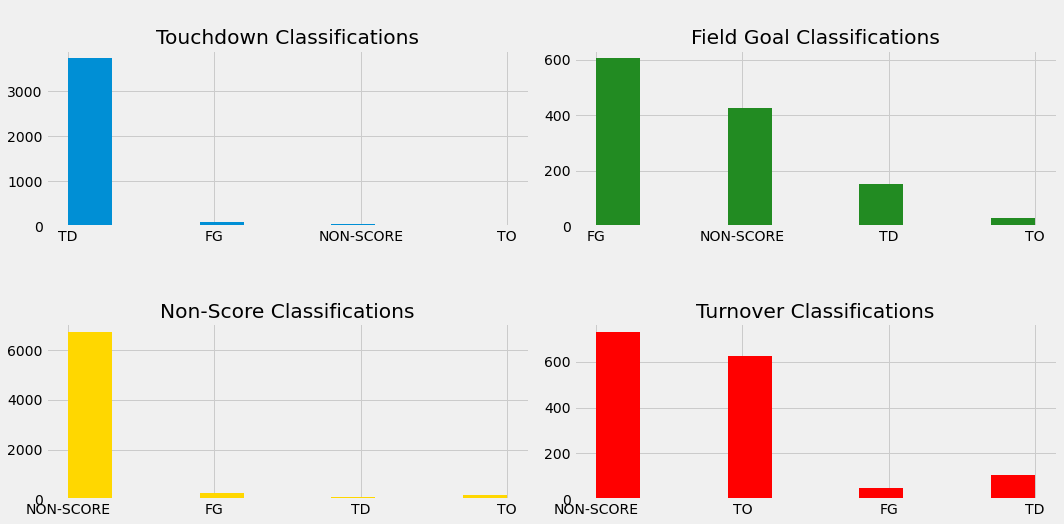

In [16]:
#get classification data
td = drives20.query('reduced_result == "TD"')['preds']
fg = drives20.query('reduced_result == "FG"')['preds']
ns = drives20.query('reduced_result == "NON-SCORE"')['preds']
to = drives20.query('reduced_result == "TO"')['preds']

#plot classification data
fig, axs = plt.subplots(2, 2)
axs[0, 0].hist(x = td)
axs[0, 0].set_title('\nTouchdown Classifications')
axs[0, 1].hist(x = fg, color = 'forestgreen')
axs[0, 1].set_title('\nField Goal Classifications')
axs[1, 0].hist(x = ns ,color = 'gold')
axs[1, 0].set_title('\n\nNon-Score Classifications')
axs[1, 1].hist(x = to, color = 'red')
axs[1, 1].set_title('\n\nTurnover Classifications')
plt.tight_layout()


In [17]:
#get dataframe of comparison between actual and predicted points 
points_per_drive = drives20.groupby('offense').agg(actual_avg = ('actual_points', 'mean'), actual_total = ('actual_points', 'sum'), pred_avg = ('predicted_points', 'mean'), pred_total = ('predicted_points', 'sum'), num_drives = ('drive_id', 'count')).sort_values('pred_avg', ascending = False).reset_index().query('num_drives > 35')
points_per_drive['diff_total'] = points_per_drive['actual_total'] - points_per_drive['pred_total']

points_per_drive.head(5)

,offense,actual_avg,actual_total,pred_avg,pred_total,num_drives,diff_total
0,Kent State,4.102041,201,4.183673,205,49,-4
1,Alabama,3.946667,592,4.040000,606,150,-14
2,BYU,3.798507,509,3.858209,517,134,-8
3,Western Michigan,3.371429,236,3.557143,249,70,-13
4,Coastal Carolina,3.330827,443,3.443609,458,133,-15


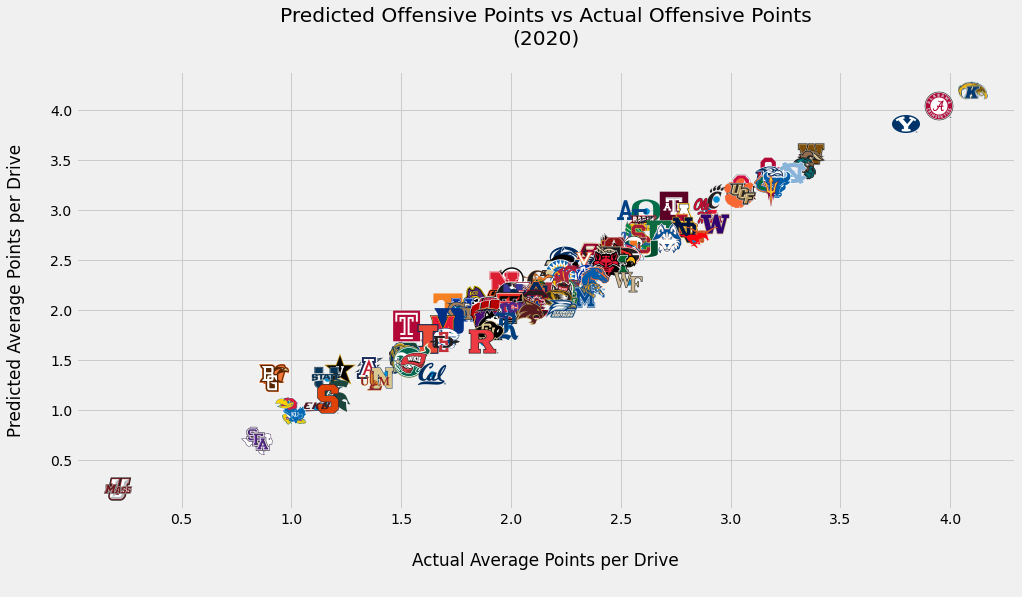

In [18]:
## Plot Actual vs Predicted Points per Drive

#define function to get paths to logos (in logos file in working directory)
def getImage(path):
    return OffsetImage(plt.imread("./logos/{0}.png".format(path)))

#get team names to put into file path later
paths = points_per_drive['offense']

x = points_per_drive['actual_avg']
y = points_per_drive['pred_avg']

#instantiate plot
fig, ax = plt.subplots()
ax.scatter(x, y) 

# Cycle through each point and add an image annotation
for x0, y0, path in zip(x, y,paths):
    ab = AnnotationBbox(getImage(path), (x0, y0), frameon=False)
    ax.add_artist(ab)

# Define labels and title
plt.title("Predicted Offensive Points vs Actual Offensive Points\n(2020)\n")
plt.xlabel('\nActual Average Points per Drive\n')
plt.ylabel('Predicted Average Points per Drive\n')
plt.show()

In [19]:
#look at over and under acheivers
points_per_drive.sort_values('diff_total', ascending = False)

## ** could use prediction intervals here and see who is outside the prediction intervals

,offense,actual_avg,actual_total,pred_avg,pred_total,num_drives,diff_total
88,Georgia Southern,2.231788,337,2.013245,304,151,33
59,Wake Forest,2.534483,294,2.275862,264,116,30
67,Memphis,2.355072,325,2.159420,298,138,27
110,Rutgers,1.871795,219,1.675214,196,117,23
31,SMU,2.833333,374,2.696970,356,132,18
...,...,...,...,...,...,...,...
41,Penn State,2.247788,254,2.530973,286,113,-32
15,Texas A&M,2.741071,307,3.035714,340,112,-33
65,Oklahoma State,1.948052,300,2.162338,333,154,-33
20,Louisiana,2.607692,339,2.876923,374,130,-35


## Look at Predictions on a Game Level -- Who Should Have Won on Average?

In [20]:
## define function to create in-game graphs

def create_graph(drives = drives20, game_id = 401247295, color1 = "black", color2 = "slategray"):
    game_drives = drives.query('game_id == @game_id')

    team_one = game_drives.offense.unique()[0]
    team_two = game_drives.offense.unique()[1]

    team_one_drives = game_drives.query('offense == @team_one')
    team_two_drives = game_drives.query('offense == @team_two')

    x1 = team_one_drives.drive_number
    x2 = team_two_drives.drive_number
    y1 = team_one_drives.predicted_points.cumsum()
    y2 = team_two_drives.predicted_points.cumsum()

    path1 = pd.Series(team_one).repeat(len(x1))
    path2 = pd.Series(team_two).repeat(len(x1))

    #instantiate plot
    fig, ax = plt.subplots()
    ax.plot(x1, y1, color = color1)
    ax.plot(x2, y2, color = color2)

    # Cycle through each point and add an image annotation
    for x0, y0, path in zip(x1, y1, path1):
        ab = AnnotationBbox(getImage(path), (x0, y0), frameon=False)
        ax.add_artist(ab)
    for x0, y0, path in zip(x2, y2, path2):
        ab = AnnotationBbox(getImage(path), (x0, y0), frameon=False)
        ax.add_artist(ab)
    
    #paste title text together
    title = ["Predicted", "Points", "per", "Drive: ", team_one, "vs.", team_two]
    
    #add labels to plot
    plt.title(" ".join(title))
    plt.xlabel("Drive Number")
    plt.ylabel("Predicted Points")
    
    #return plot
    return(plt.show())

## Penn State @ Indiana (2020)
### Actual Score: Penn State   35  -  36   Indiana

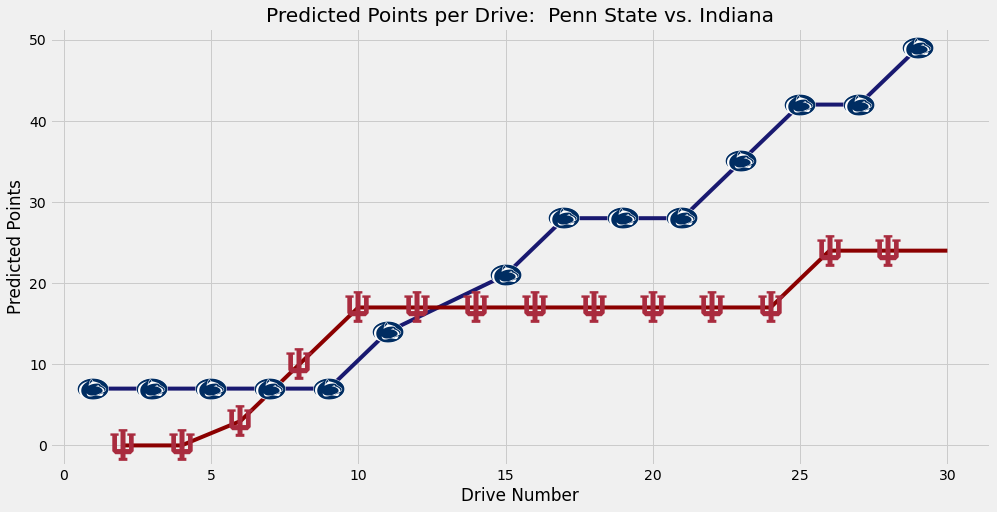

In [21]:
create_graph(drives = drives20, game_id = 401247295, color1 = "midnightblue", color2 = "darkred")

## BYU @ Coastal Carolina (2020)
### Actual Score: BYU   17  -  22   Coastal Carolina

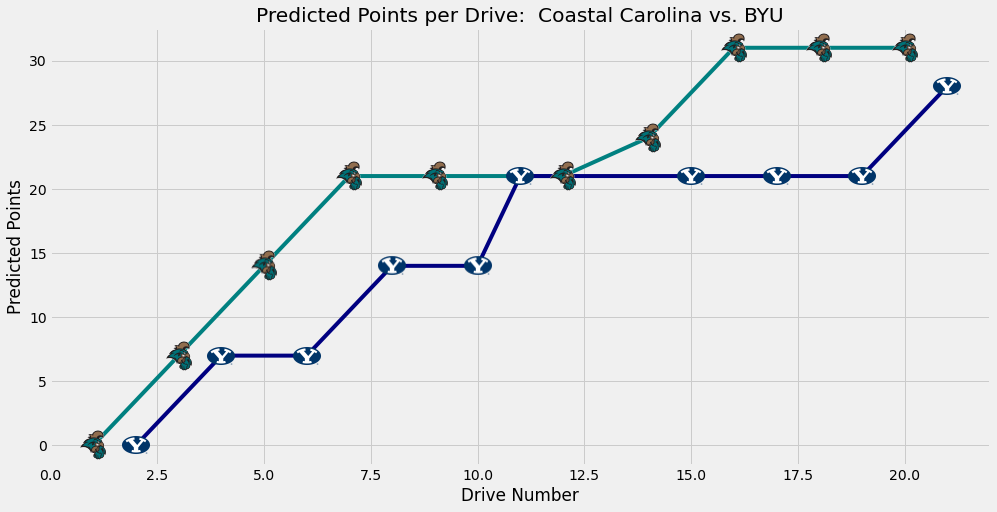

In [22]:
create_graph(drives = drives20, game_id = 401237514, color1 = "teal", color2 = "navy")

## BYU @ Utah (2018)
### Actual Score: BYU   27  -  35   Utah
***Note: The data from this game was used to train/test the model

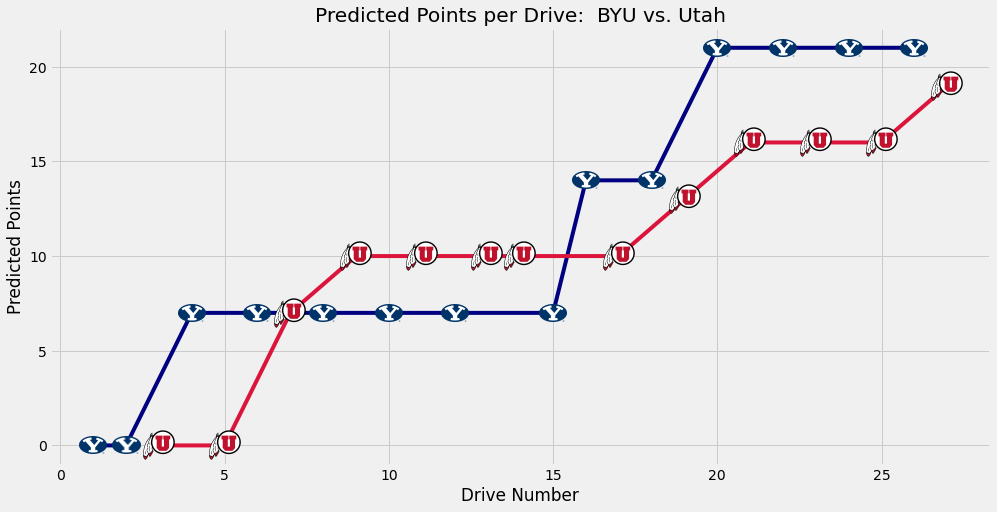

In [23]:
create_graph(drives = drives18, game_id = 401012802, color1 = "navy", color2 = "crimson")

## BYU vs UTSA (2020)
### Actual Score: BYU   27  -  20   UTSA

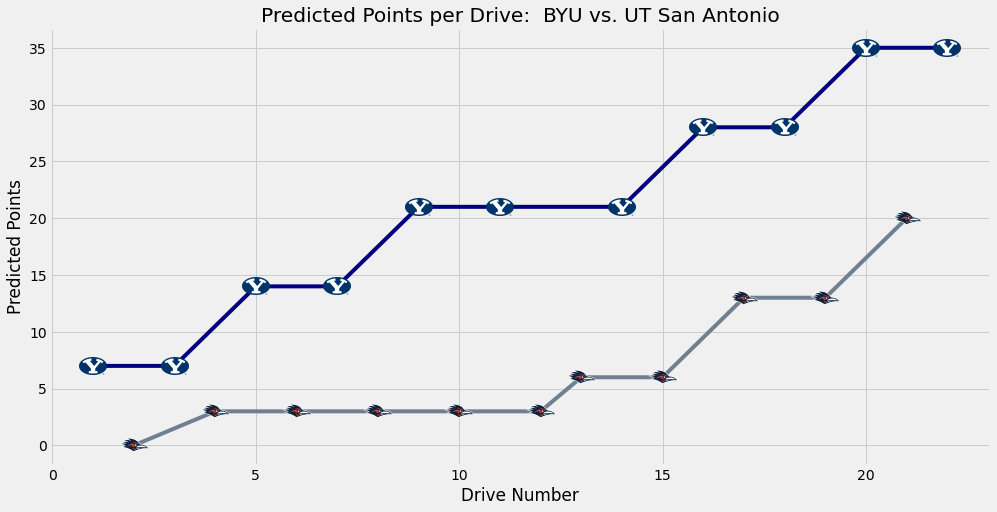

In [24]:
create_graph(game_id = 401240997, color1 = "navy")

## Clemson @ Notre Dame (2020)
### Actual Score: Clemson   40  -  47   Notre Dame

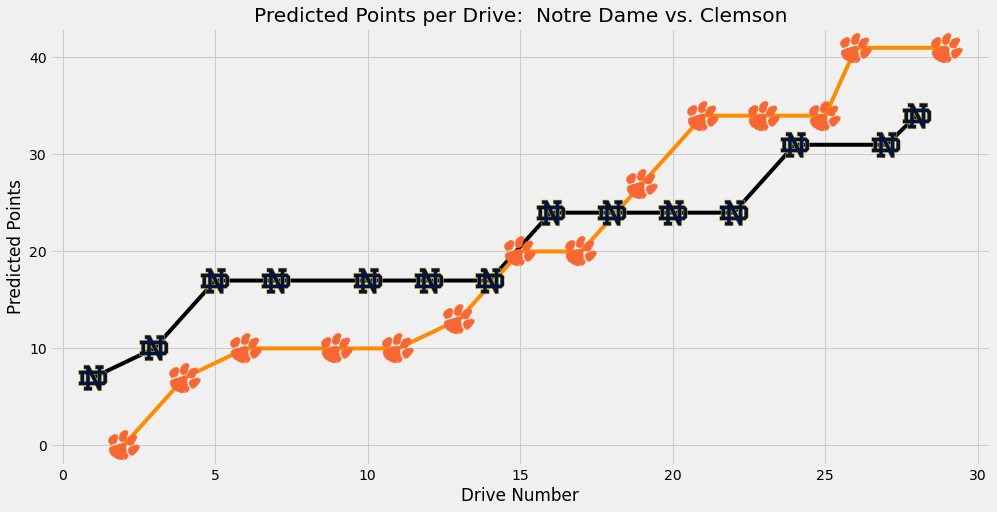

In [25]:
create_graph(game_id = 401234632, color2 = "darkorange")